In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm import tqdm
from dataset import TensorClassificationDataset
from baseline_model import MarineMammalInceptionNet
from evaluation import evaluate_model, plot_calibration_curve

## Load dataset and initialize model

Scanning directories for class distribution...


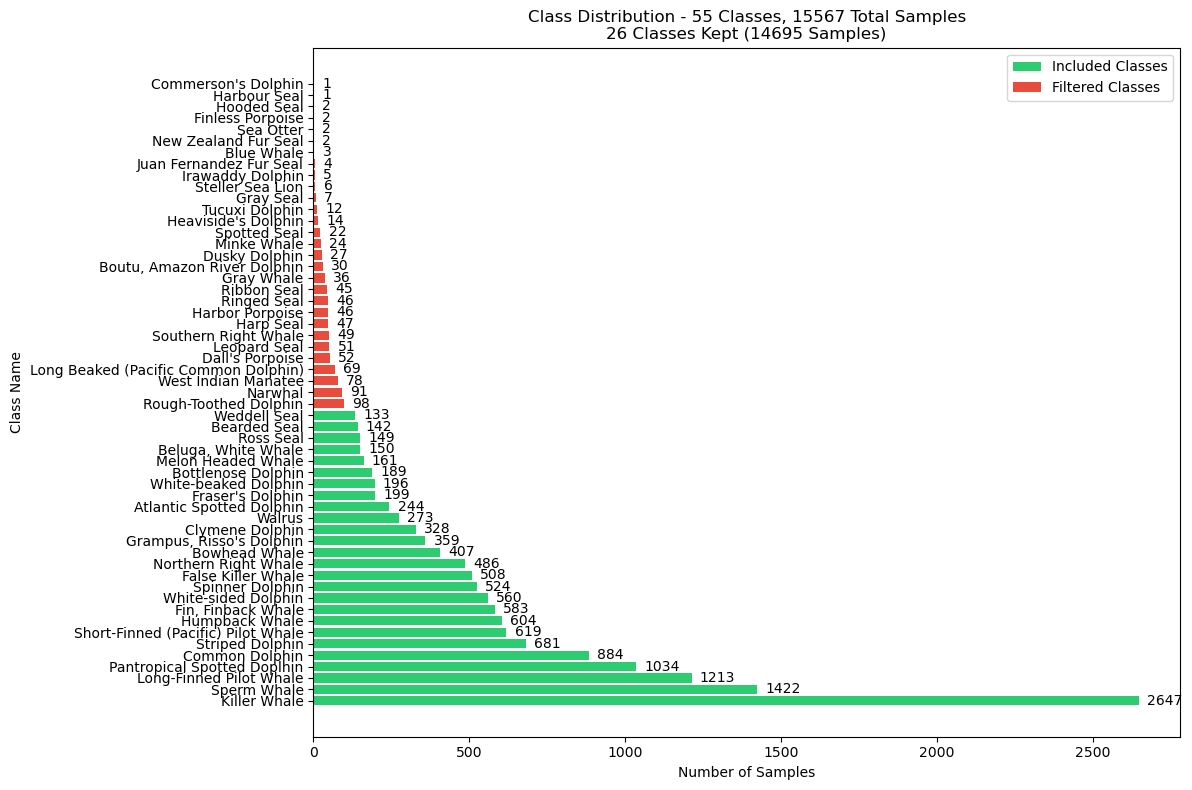

<Figure size 1200x1650 with 0 Axes>

Dataset Summary:
  - Total classes: 55
  - Classes meeting min_samples threshold: 26
  - Total samples: 15567
  - Kept samples: 14695 (94.4%)
  - Min samples per class: 1
  - Max samples per class: 2647
  - Avg samples per class: 283.0
Filtered out 29 classes with fewer than 100 samples
Preloading 14695 tensor files from 26 classes...


Loading tensors: 100%|██████████| 14695/14695 [03:18<00:00, 73.94it/s]

Successfully loaded 14695 tensors


In [2]:
root_dir = "data/preprocessed"
# Keep only labels with at least 100 examples
dataset = TensorClassificationDataset(root_dir, min_samples=100)

In [3]:
num_classes = len(dataset.class_names)
class_weights = dataset.get_class_weights()

In [4]:
model = MarineMammalInceptionNet(len(dataset.class_names))

## Stratified split dataset into train and test. Use SEED=42 for consistency

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Subset

SEED = 42

# First, get all indices from your dataset
indices = list(range(len(dataset)))

# Split indices
train_indices, test_indices = train_test_split(
    indices, test_size=0.2, random_state=SEED, stratify=[dataset.labels[i] for i in indices]
)

# Create Subset objects
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=3072, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=3072, shuffle=False, num_workers=4)

## Training

In [6]:
# Example training setup
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 3000

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Calculate total steps for the scheduler
total_steps = len(train_loader) * num_epochs

# Define the learning rate scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.01,  # Maximum learning rate at the peak of the cycle
    total_steps=total_steps,
    pct_start=0.3,  # Percentage of steps spent in the increasing phase
    anneal_strategy='cos',  # Cosine annealing for decreasing phase
    div_factor=25.0,  # Initial learning rate = max_lr/div_factor
    final_div_factor=1000.0  # Final learning rate = initial_lr/final_div_factor
)

In [7]:
import time
import torch
import datetime

# Training loop with time and GPU memory tracking
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Step the scheduler (OneCycleLR is updated per batch)
        scheduler.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_time = time.time() - epoch_start
    
    # Get GPU memory usage
    gpu_memory_used = 0
    if torch.cuda.is_available():
        # Get current GPU memory usage in MB
        gpu_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)
        # Reset peak memory stats for next epoch
        torch.cuda.reset_peak_memory_stats()
    
    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]
    
    # Format time as hours:minutes:seconds
    epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
    total_time_str = str(datetime.timedelta(seconds=int(time.time() - start_time)))
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}, Time: {epoch_time_str}, GPU Memory: {gpu_memory_used:.1f} MB, Total Time: {total_time_str}')

# Report final training statistics
total_training_time = time.time() - start_time
print(f'Finished Training in {str(datetime.timedelta(seconds=int(total_training_time)))}')
torch.save(model.state_dict(), "checkpoints/baseline_model.pth")

Epoch 1/3000, Loss: 3.2452, LR: 0.000400, Time: 0:00:03, GPU Memory: 11109.6 MB, Total Time: 0:00:03
Epoch 2/3000, Loss: 3.1677, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:04
Epoch 3/3000, Loss: 3.1129, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:05
Epoch 4/3000, Loss: 3.0407, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:06
Epoch 5/3000, Loss: 2.9727, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:07
Epoch 6/3000, Loss: 2.9114, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:09
Epoch 7/3000, Loss: 2.8410, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:10
Epoch 8/3000, Loss: 2.7507, LR: 0.000402, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:11
Epoch 9/3000, Loss: 2.6654, LR: 0.000402, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:12
Epoch 10/3000, Loss: 2.5503, LR: 0.000403, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Tim

## Inference and evaluation

In [8]:
print("Evaluating on training set...")
train_metrics = evaluate_model(model, train_loader, device)

# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate_model(model, test_loader, device)

# Print metrics
print("\n===== Training Set Metrics =====")
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {train_metrics['ece']:.4f}")
print(f"Mean Entropy: {train_metrics['mean_entropy']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(train_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {train_metrics['inference_time_per_sample']*1000:.2f} ms")

print("\n===== Test Set Metrics =====")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {test_metrics['ece']:.4f}")
print(f"Mean Entropy: {test_metrics['mean_entropy']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(test_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {test_metrics['inference_time_per_sample']*1000:.2f} ms")

Evaluating on training set...

Evaluating on test set...

===== Training Set Metrics =====
Accuracy: 0.5584
Precision: 0.6692
Recall: 0.5584
F1 Score: 0.5115
Expected Calibration Error: 0.3384
Mean Entropy: 0.2676
Inference Time: 0:00:00
Inference Time per Sample: 0.04 ms

===== Test Set Metrics =====
Accuracy: 0.4777
Precision: 0.5744
Recall: 0.4777
F1 Score: 0.4329
Expected Calibration Error: 0.4085
Mean Entropy: 0.2997
Inference Time: 0:00:00
Inference Time per Sample: 0.09 ms


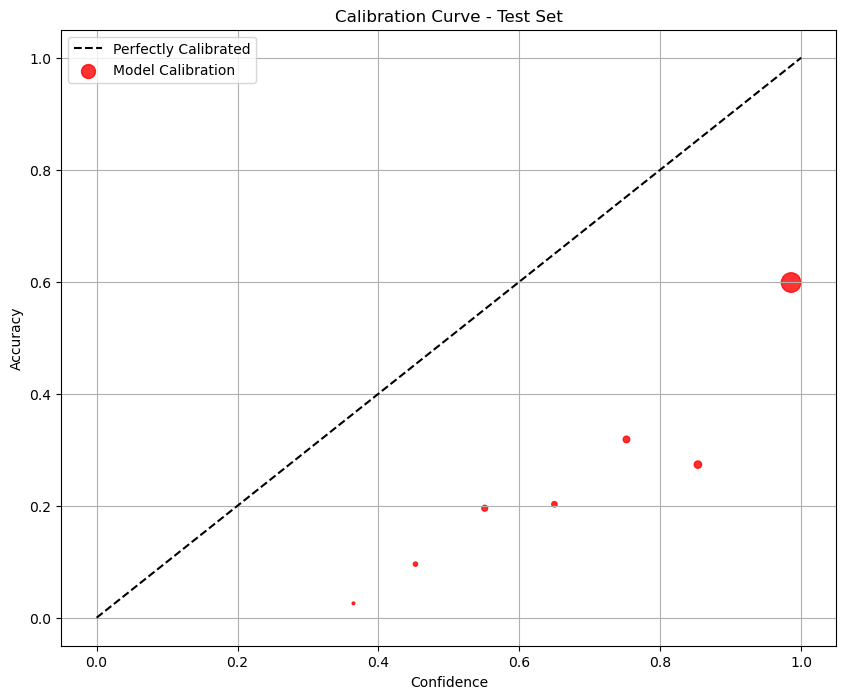

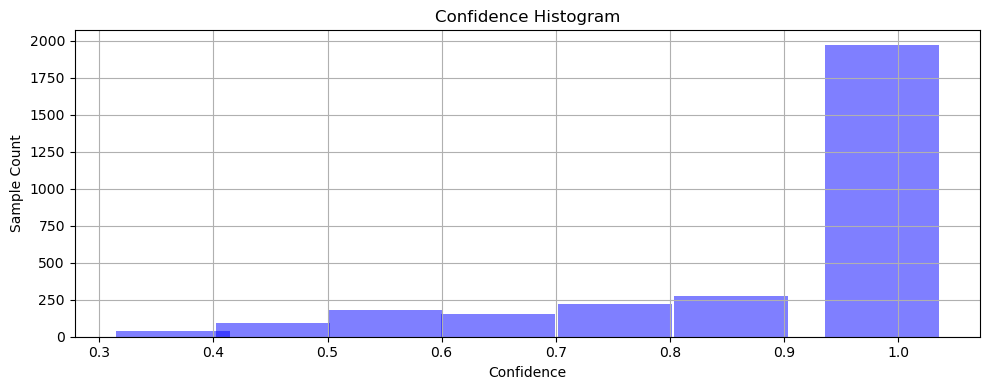

In [9]:
# Plot calibration curve for test set
plot_calibration_curve(
    test_metrics['bin_accuracies'], 
    test_metrics['bin_confidences'], 
    test_metrics['bin_counts'],
    'Calibration Curve - Test Set'
)